# **08 Predictive model**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write down which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Baseline model

Import packages

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline

In [99]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned.csv')
df.head(10)

,transaction,price,transfer_date,postcode,property_type,new_build,tenure,PAON,SAON,Street,...,is_new_build_energy_band_num,outcode,log_price,log_total_floor_area,is_flat,is_leasehold,is_flat_leasehold,new_build_energy_band_num,property_type_order,property_type_order_legend
0,{3DCCB7C9-D19E-5B9D-E063-4704A8C0331E},79000,1996-11-29,S18 1QH,D,0,F,27,NaN,HOLBEIN CLOSE,...,0,S18,11.277216,5.056373,False,False,False,0,4,4 - D
1,{3DCCB7CA-8C30-5B9D-E063-4704A8C0331E},192000,2005-03-14,B44 0JR,S,0,F,56,NaN,HORNSEY ROAD,...,0,B44,12.165256,4.355041,False,False,False,0,3,3 - S
2,{3DCCB7CA-8CCC-5B9D-E063-4704A8C0331E},170000,2005-05-20,DY4 7NY,S,1,F,22,NaN,DARBYS WAY,...,4,DY4,12.043560,4.634729,False,False,False,4,3,3 - S
3,{3DCCB7C9-D364-5B9D-E063-4704A8C0331E},450000,2006-03-17,DE7 6GU,D,0,F,3,NaN,BEECH LANE,...,0,DE7,13.017005,4.060443,False,False,False,0,4,4 - D
4,{3DCCB7CA-8D25-5B9D-E063-4704A8C0331E},124950,2008-06-11,DY8 3UJ,T,0,F,76,NaN,SOUTH ROAD,...,0,DY8,11.735677,4.117898,False,False,False,0,2,2 - T
5,{3DCCB7CA-8AEF-5B9D-E063-4704A8C0331E},285000,2015-03-28,B31 2SQ,S,0,F,12,NaN,KEMSHEAD AVENUE,...,0,B31,12.560248,4.369448,False,False,False,0,3,3 - S
6,{3DCCB7CA-8E32-5B9D-E063-4704A8C0331E},282500,2015-07-18,B97 6AX,S,0,F,26,NaN,MARTON CLOSE,...,0,B97,12.551437,4.564348,False,False,False,0,3,3 - S
7,{3DCCB7CA-4BEC-5B9D-E063-4704A8C0331E},322500,2015-07-23,ST5 3AF,D,0,F,25,NaN,CLAYTON ROAD,...,0,ST5,12.683862,5.214283,False,False,False,0,4,4 - D
8,{3DCCB7CA-1DDC-5B9D-E063-4704A8C0331E},241000,2015-07-25,LE67 3BY,S,0,F,1,NaN,HEADSTOCK CLOSE,...,0,LE67,12.392556,4.543295,False,False,False,0,3,3 - S
9,{3DCCB7C9-D317-5B9D-E063-4704A8C0331E},270000,2015-07-31,DE73 6RL,D,0,F,15,NaN,HILLCRESTE DRIVE,...,0,DE73,12.506181,4.442651,False,False,False,0,4,4 - D


---

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transaction                   7248 non-null   object 
 1   price                         7248 non-null   int64  
 2   transfer_date                 7248 non-null   object 
 3   postcode                      7248 non-null   object 
 4   property_type                 7248 non-null   object 
 5   new_build                     7248 non-null   int64  
 6   tenure                        7248 non-null   object 
 7   PAON                          7248 non-null   object 
 8   SAON                          371 non-null    object 
 9   Street                        7219 non-null   object 
 10  Locality                      3020 non-null   object 
 11  town_city                     7248 non-null   object 
 12  district                      7248 non-null   object 
 13  cou

In [101]:
# what about county
df["county"].unique()
df["county"].value_counts()

county
WEST MIDLANDS     2179
STAFFORDSHIRE     1027
LEICESTERSHIRE     981
DERBYSHIRE         933
WARWICKSHIRE       755
WORCESTERSHIRE     712
CITY OF DERBY      240
STOKE-ON-TRENT     231
LEICESTER          190
Name: count, dtype: int64

In [102]:
# Use sales from 2024 onwards for the baseline model
df = df[(df['year'] >= 2024)]
# sort by date
df = df.sort_values(by='transfer_date')
df.head(10)
df.tail(10)


,transaction,price,transfer_date,postcode,property_type,new_build,tenure,PAON,SAON,Street,...,is_new_build_energy_band_num,outcode,log_price,log_total_floor_area,is_flat,is_leasehold,is_flat_leasehold,new_build_energy_band_num,property_type_order,property_type_order_legend
7232,{3DCCB7CA-4CF1-5B9D-E063-4704A8C0331E},155000,2025-08-27,ST3 5AE,T,0,F,52,NaN,HILLGREEN ROAD,...,0,ST3,11.951187,4.317488,False,False,False,0,2,2 - T
7231,{3DCCB7CA-4E21-5B9D-E063-4704A8C0331E},85000,2025-08-27,ST4 7PL,T,0,F,446,NaN,HARTSHILL ROAD,...,0,ST4,11.350418,4.317488,False,False,False,0,2,2 - T
7230,{3DCCB7CA-8B7E-5B9D-E063-4704A8C0331E},212500,2025-08-27,B45 8QS,S,0,F,34,NaN,HERONSWOOD ROAD,...,0,B45,12.266702,4.276666,False,False,False,0,3,3 - S
7235,{3DCCB7CA-8B4B-5B9D-E063-4704A8C0331E},718000,2025-08-27,B14 6AT,S,0,F,133,NaN,ALL SAINTS ROAD,...,0,B14,13.484226,5.236442,False,False,False,0,3,3 - S
7246,{3DCCB7CA-8930-5B9D-E063-4704A8C0331E},170000,2025-08-28,B36 9TZ,T,0,F,2,NaN,PIKEHORNE CROFT,...,0,B36,12.043560,4.204693,False,False,False,0,2,2 - T
7242,{3DCCB7CA-8B4F-5B9D-E063-4704A8C0331E},225000,2025-08-28,B26 3DJ,T,0,F,53,NaN,BICKLEY GROVE,...,0,B26,12.323860,4.356709,False,False,False,0,2,2 - T
7243,{3DCCB7CA-2668-5B9D-E063-4704A8C0331E},208000,2025-08-28,B13 8JT,F,0,L,52A,FLAT 6,SALISBURY ROAD,...,0,B13,12.245298,4.369448,False,False,False,0,1,1 - F
7244,{3DCCB7CA-8BF1-5B9D-E063-4704A8C0331E},170000,2025-08-28,B13 9PS,F,0,L,14,NaN,AVON DRIVE,...,0,B13,12.043560,4.290459,False,False,False,0,1,1 - F
7245,{3DCCB7C9-D2EC-5B9D-E063-4704A8C0331E},320000,2025-08-28,NG10 1PP,D,0,F,8,NaN,TEWKESBURY ROAD,...,0,NG10,12.676079,4.584967,False,False,False,0,4,4 - D
7247,{3DCCB7CA-4D3F-5B9D-E063-4704A8C0331E},250000,2025-08-29,ST13 8XF,D,0,F,3,NaN,THE WILLOWS,...,0,ST13,12.429220,4.043051,False,False,False,0,4,4 - D


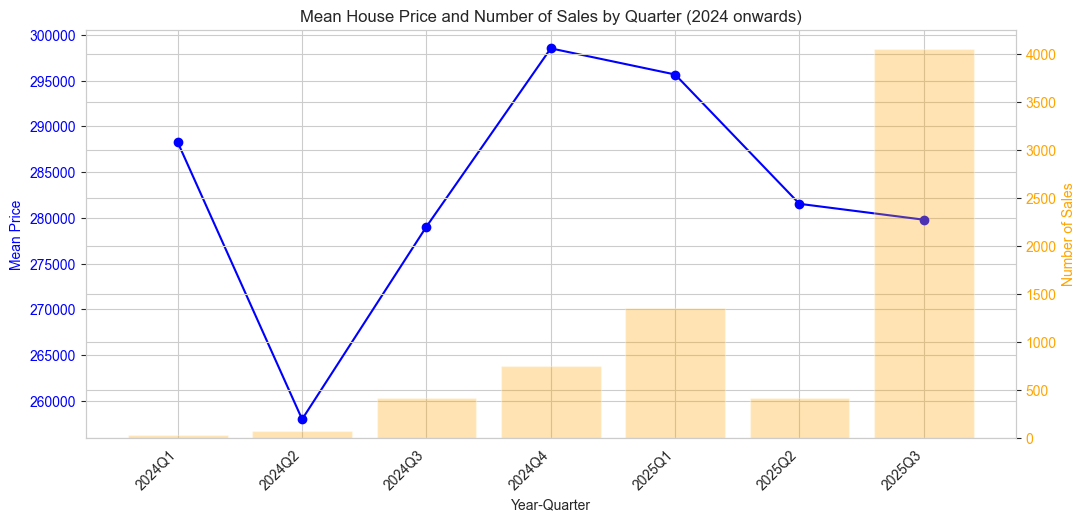

In [103]:
# test on the latest 20% of the data using the transfer_date
# sort the DataFrame by transfer_date
# make it a true datetime?
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
# keep only the transfer_date for 2024 onwards
df = df[df['transfer_date'].dt.year >= 2024]
# use year_quarter for grouping
df['year_quarter'] = df['transfer_date'].dt.to_period('Q')
mean_price_by_quarter = df.groupby('year_quarter')['price'].mean()
number_of_sales_by_quarter = df['year_quarter'].value_counts().sort_index()

# plot mean price as a line and number of sales as a bar chart on the same plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(mean_price_by_quarter.index.astype(str), mean_price_by_quarter.values, color='blue', marker='o', label='Mean Price')
ax2.bar(number_of_sales_by_quarter.index.astype(str), number_of_sales_by_quarter.values, alpha=0.3, color='orange', label='Number of Sales')
ax1.set_xlabel('Year-Quarter')
ax1.set_ylabel('Mean Price', color='blue')
ax2.set_ylabel('Number of Sales', color='orange')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')
plt.title('Mean House Price and Number of Sales by Quarter (2024 onwards)')
fig.autofmt_xdate(rotation=45)
plt.show()

In [104]:
# Use only main-effect features for the baseline:
# Numeric: total_floor_area, IMD_Decile, year, new_build, is_leasehold, energy_band_num.
# Categorical: property_type (one-hot), and county (one-hot)

# Define numeric features and categorical features
feature_cols = [
    'log_total_floor_area', 
    'IMD_Decile', 
    'year', 
    'new_build', 
    'is_leasehold', 
    'energy_band_num',
    ]

# Add one-hot encoded property_type
property_type_dummies = pd.get_dummies(df['property_type'], prefix='property_type', drop_first=True)
feature_cols.extend(property_type_dummies.columns.tolist())
df = pd.concat([df, property_type_dummies], axis=1)

# Add one-hot encoded county columns
county_dummies = pd.get_dummies(df['county'], prefix='county', drop_first=True)
feature_cols.extend(county_dummies.columns.tolist())
df = pd.concat([df, county_dummies], axis=1)


In [105]:
df.head()


,transaction,price,transfer_date,postcode,property_type,new_build,tenure,PAON,SAON,Street,...,property_type_S,property_type_T,county_DERBYSHIRE,county_LEICESTER,county_LEICESTERSHIRE,county_STAFFORDSHIRE,county_STOKE-ON-TRENT,county_WARWICKSHIRE,county_WEST MIDLANDS,county_WORCESTERSHIRE
164,{3DCCB7CA-86B0-5B9D-E063-4704A8C0331E},177000,2024-01-04,CV34 5GQ,F,0,L,28,NaN,BIRCH END,...,False,False,False,False,False,False,False,True,False,False
165,{3DCCB7CA-1F01-5B9D-E063-4704A8C0331E},125000,2024-01-12,LE18 1JW,F,0,F,289B,NaN,LEICESTER ROAD,...,False,False,False,False,True,False,False,False,False,False
166,{3DCCB7CA-83D3-5B9D-E063-4704A8C0331E},160000,2024-01-15,B42 2RL,S,0,F,31,NaN,CADDICK ROAD,...,True,False,False,False,False,False,False,False,True,False
167,{3DCCB7CA-4BDA-5B9D-E063-4704A8C0331E},132000,2024-01-16,ST3 2AE,S,0,F,25,NaN,ASH GROVE,...,True,False,False,False,False,False,True,False,False,False
168,{3DCCB7CA-8767-5B9D-E063-4704A8C0331E},180000,2024-01-26,CV37 8ZB,F,1,L,7,NaN,MALLARD COURT,...,False,False,False,False,False,False,False,True,False,False


In [106]:
# Target is log_price
X = df[feature_cols]
y = df['log_price']
X.head()
y.head()
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# split the data into training and testing sets based on the latest 20%
split_index = int(len(df) * 0.8)
train = df[:split_index]
test = df[split_index:]

X_train = train[feature_cols]
y_train = train['log_price']
X_test = test[feature_cols]
y_test = test['log_price']

# Train a baseline model (Linear Regression)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Absolute Error: 0.17761882551634112
Mean Squared Error: 0.05494894503488934
R^2 Score: 0.7403051767614249


Plot and compare the test set predictions vs actuals and save the results


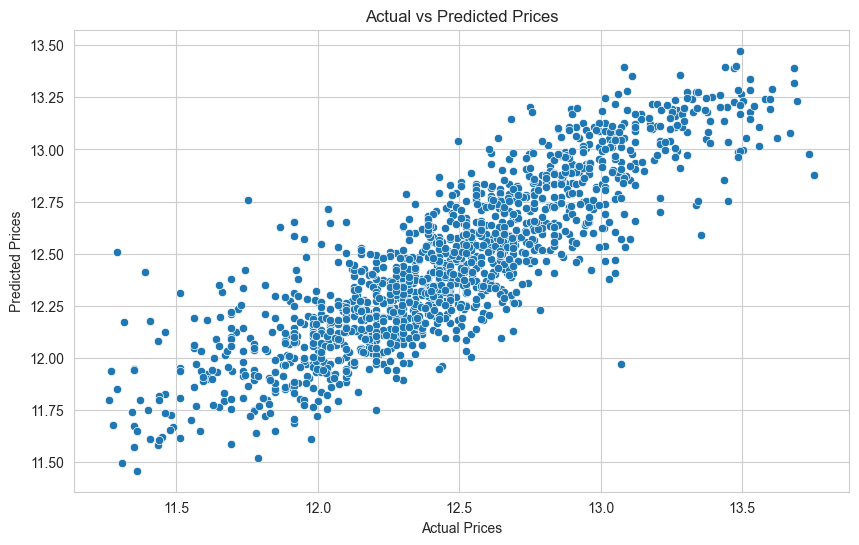

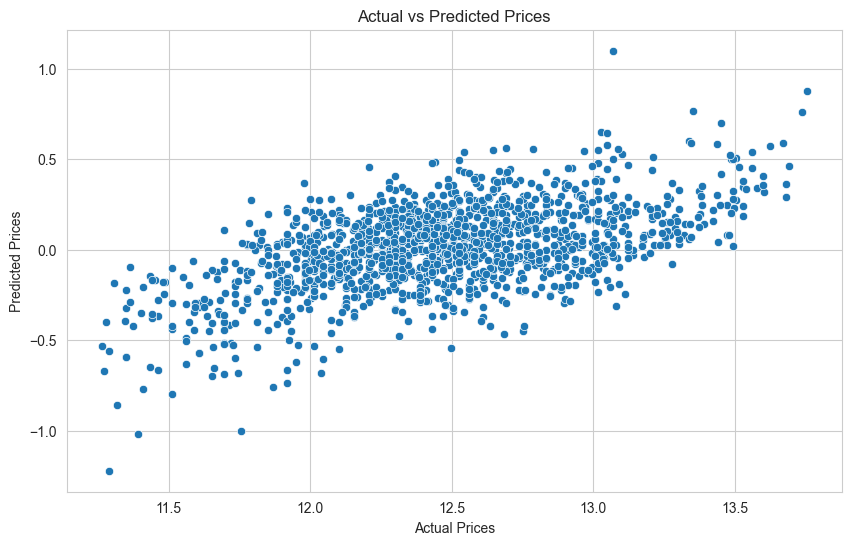

In [107]:
# plot the test set predictions vs actuals
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# plot the residuals
residuals = y_test - y_pred
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# save the test set for future evaluation
test.to_csv('../data/clean/test_set.csv', index=False)


# Section 2

Section 2 content